# Проект QA

## Yes/No Questions

Вы будете работать с корпусом BoolQ. Корпус состоит из вопросов, предполагающих бинарный ответ (да / нет), абзацев из Википедии,  содержащих ответ на вопрос, заголовка статьи, из которой извлечен абзац и непосредственно ответа (true / false).

Корпус описан в статье:

Christopher Clark, Kenton Lee, Ming-Wei Chang, Tom Kwiatkowski, Michael Collins, Kristina Toutanova
BoolQ: Exploring the Surprising Difficulty of Natural Yes/No Questions

https://arxiv.org/abs/1905.10044


Корпус (train-dev split) доступен в репозитории проекта:  https://github.com/google-research-datasets/boolean-questions

Используйте для обучения train часть корпуса, для валидации и тестирования – dev часть. 

Каждый бонус пункт оцениватся в 1 балл. 

In [1]:
# !gsutil cp gs://boolq/train.jsonl .
# !gsutil cp gs://boolq/dev.jsonl .

### Пример вопроса: 
question: is batman and robin a sequel to batman forever

title: Batman & Robin (film)

answer: true

passage: With the box office success of Batman Forever in June 1995, Warner Bros. immediately commissioned a sequel. They hired director Joel Schumacher and writer Akiva Goldsman to reprise their duties the following August, and decided it was best to fast track production for a June 1997 target release date, which is a break from the usual 3-year gap between films. Schumacher wanted to homage both the broad camp style of the 1960s television series and the work of Dick Sprang. The storyline of Batman & Robin was conceived by Schumacher and Goldsman during pre-production on A Time to Kill. Portions of Mr. Freeze's back-story were based on the Batman: The Animated Series episode ''Heart of Ice'', written by Paul Dini.

## Часть 1. Эксплоративный анализ
1. Посчитайте долю yes и no классов в корпусе
2. Оцените среднюю длину вопроса
3. Оцените среднюю длину параграфа
4. Предположите, по каким эвристикам были собраны вопросы (или найдите ответ в статье). Продемонстриуйте, как эти эвристики повлияли на структуру корпуса. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl

True: 62.31%


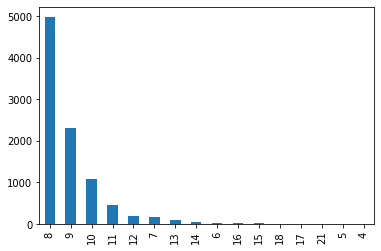

In [2]:
train = pd.read_json('train.jsonl', lines=True, orient='records')

print('True: {}%'
    .format((train['answer']
    .value_counts()[1]/train.shape[0]*100)
    .round(2)))
train['question'].str.split().apply(len).value_counts().plot.bar()

In [3]:
from functools import reduce
from math import *

avg_question_words = reduce(lambda x,y: x + y,
    list(map(lambda x: len(x.split()),train['question'].to_list())))/train.shape[0]
avg_question_symbols = reduce(lambda x,y: x + y,
    list(map(lambda x: len(x),train['question'].to_list())))/train.shape[0]

avg_passage_words = reduce(lambda x,y: x + y,
    list(map(lambda x: len(x.split()),train['passage'].to_list())))/train.shape[0]
avg_passage_symbols = reduce(lambda x,y: x + y,
    list(map(lambda x: len(x),train['passage'].to_list())))/train.shape[0]


print('''
    Q_avg_words: {}
    Q_avg_symbols: {}
    P_avg_words: {}
    P_avg_symbols: {}
    '''.format(round(avg_question_words,2),
        round(avg_question_symbols,2),
        round(avg_passage_words,2),
        round(avg_passage_symbols,2)))


    Q_avg_words: 8.82
    Q_avg_symbols: 43.99
    P_avg_words: 93.17
    P_avg_symbols: 565.61
    


In [4]:

max_question_words = reduce(lambda x,y: max(x,y),
    list(map(lambda x: len(x.split()),train['question'].to_list())))
max_question_symbols = reduce(lambda x,y: max(x,y),
    list(map(lambda x: len(x),train['question'].to_list())))

max_passage_words = reduce(lambda x,y: max(x,y),
    list(map(lambda x: len(x.split()),train['passage'].to_list())))
max_passage_symbols = reduce(lambda x,y: max(x,y),
    list(map(lambda x: len(x),train['passage'].to_list())))


print('''
    Q_max_words: {}
    Q_max_symbols: {}
    P_max_words: {}
    P_max_symbols: {}
    '''.format(round(max_question_words,2),
        round(max_question_symbols,2),
        round(max_passage_words,2),
        round(max_passage_symbols,2)))


    Q_max_words: 21
    Q_max_symbols: 100
    P_max_words: 754
    P_max_symbols: 4720
    


## Часть 2. Baseline
1. Оцените accuracy точность совсем простого базового решения: присвоить каждой паре вопрос-ответ в dev части самый частый класс из train части
2. Оцените accuracy чуть более сложного базового решения: fasttext на текстах, состоящих из склееных вопросов и абзацев (' '.join([question, passage]))

Почему fasttext плохо справляется с этой задачей?

In [5]:
from sklearn.metrics import accuracy_score
import fasttext


test = pd.read_json('dev.jsonl', lines=True, orient='records')

y = test['answer']
y_pred = pd.Series([True for i in range(test.shape[0])])


accuracy_score(y, y_pred)

fasttext_train = '__label__' + train['answer'].astype(int).astype(str) + ' ' + train['question'] + ' ' + train['passage']
fasttext_test = '__label__' + test['answer'].astype(int).astype(str) + ' ' + test['question'] + ' ' + test['passage']


np.savetxt('fasttext_train.train', fasttext_train.values, fmt='%s')
np.savetxt('fasttext_test.test', fasttext_test.values, fmt='%s')

model = fasttext.train_supervised(input='fasttext_train.train')

model.test('fasttext_test.test')[1]

0.6449541284403669

## Часть 3. Используем эмбеддинги предложений
1. Постройте BERT эмбеддинги вопроса и абзаца. Обучите логистическую регрессию на конкатенированных эмбеддингах вопроса и абзаца и оцените accuracy этого решения. 

[bonus] Используйте другие модели эмбеддингов, доступные, например, в библиотеке 🤗 Transformers. Какая модель эмбеддингов даст лучшие результаты?

[bonus] Предложите метод аугментации данных и продемонстрируйте его эффективность. 

In [6]:
from tqdm import tqdm, trange

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, RandomSampler, Dataset

import transformers

from catalyst.dl import SupervisedRunner
from catalyst.dl.callbacks import AccuracyCallback, SchedulerCallback, F1ScoreCallback
from catalyst.utils import set_global_seed, prepare_cudnn

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



import re
import nltk
import string
from nltk.corpus import stopwords

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning:

numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject



In [7]:
def text_prepare(text):
    """
        text: a string
        
    """
    text = text.lower()
    text = re.sub(r'[{}]'.format(string.punctuation), '', text)
    text = re.sub('[^A-Za-z\. ]', '', text)
    stopWords = set(stopwords.words('english'))
    for stopWord in stopWords:
        # text = text.replace(stopWord, '')
        text = re.sub('^{}$'.format(stopWord), '', text)
    return text

<>:8: DeprecationWarning:

invalid escape sequence \.



In [8]:
bert_train = pd.DataFrame()
bert_train['sentence'] = (train['question'] + ' ' + train['passage']).apply(text_prepare)
bert_train['label'] = train['answer'].astype(int)
bert_test_valid = pd.DataFrame()
bert_test_valid['sentence'] = (test['question'] + ' ' + test['passage']).apply(text_prepare)
bert_test_valid['label'] = test['answer'].astype(int)

bert_test, bert_valid = train_test_split(bert_test_valid, test_size=0.5)


model_name = 'bert-base-uncased'
tokenizer = transformers.AutoTokenizer.from_pretrained(model_name)

In [9]:
bert_train.shape

(9427, 2)

In [10]:
class TextClassificationDataset(Dataset):
    def __init__(self, data, tokenizer):
        max_seq_length = 775
        
        self.data = data
        self.tokenizer = tokenizer
        self.encoded_plus = [ 
            tokenizer.encode_plus(item, max_length=max_seq_length, pad_to_max_length=True) 
            for item in data['sentence']
        ]
        
        self.input_ids = torch.tensor([ i['input_ids'] for i in self.encoded_plus ], dtype=torch.long) 
        self.attention_mask = torch.tensor([ i['attention_mask'] for i in self.encoded_plus ], dtype=torch.long) 
        self.token_type_ids = torch.tensor([ i['token_type_ids'] for i in self.encoded_plus ], dtype=torch.long) 
        self.target = torch.tensor(list(self.data['label']), dtype=torch.long) 


    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'token_type_ids': self.token_type_ids[idx],
            'targets': self.target[idx]
        }

In [11]:
class BertForSequenceClassification(nn.Module):
    def __init__(self, pretrained_model_name: str, num_labels: int):
        super().__init__()
        
        config = transformers.AutoConfig.from_pretrained(
            pretrained_model_name,
            num_labels = num_labels
        )
        
        self.bert = transformers.BertModel.from_pretrained(
            pretrained_model_name, 
            num_labels=num_labels
        )
        self.classifier = nn.Linear(config.hidden_size, num_labels)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)


    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None):
        
        assert attention_mask is not None, "attention mask is none"
        bert_output = self.bert(input_ids=input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids)
        hidden_state = bert_output[0]  # (bs, seq_len, dim)
        pooled_output = hidden_state[:, 0]  # (bs, dim)
        pooled_output = self.dropout(pooled_output)  # (bs, dim)
        
        logits = self.classifier(pooled_output)  # (bs, dim)

        return logits

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 2

pretrained_model_name = 'google/bert_uncased_L-4_H-256_A-4'
tokenizer = transformers.BertTokenizer.from_pretrained(pretrained_model_name)
model = BertForSequenceClassification(pretrained_model_name, num_labels=num_labels)

model.to(device)
print("Success!")


batch_size = 8

train_dataset = TextClassificationDataset(bert_train, tokenizer)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)

valid_dataset = TextClassificationDataset(bert_valid, tokenizer)
valid_sampler = RandomSampler(valid_dataset)
valid_dataloader = DataLoader(valid_dataset, sampler=valid_sampler, batch_size=batch_size)

test_dataset = TextClassificationDataset(bert_test, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

dataloaders = {
    "train": train_dataloader,
    "valid": valid_dataloader,
    "test": test_dataloader    
}

print(f"Dataset size: {len(train_dataloader)}")


Success!
Dataset size: 1179


In [13]:
seed = 404
set_global_seed(seed)
prepare_cudnn(True)

epochs = 8
lr = 1e-5
warmup_steps = len(train_dataloader) // 2
t_total = len(train_dataloader) * epochs


optimizer_grouped_parameters = [
    {"params": [p for n, p in model.named_parameters()], "weight_decay": 0.0},
]

criterion = torch.nn.CrossEntropyLoss()
optimizer = transformers.AdamW(optimizer_grouped_parameters, lr=lr)
scheduler = transformers.get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total
)


log_dir = 'logs/'


torch.cuda.empty_cache()
torch.cuda.is_available()

True

In [14]:
train_val_loaders = {
    "train": train_dataloader,
    "valid": valid_dataloader
}

runner = SupervisedRunner(
    input_key=(
        "input_ids",
        "attention_mask",
        "token_type_ids"
    )
)

runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    loaders=train_val_loaders,
    callbacks=[
        AccuracyCallback(num_classes=num_labels),
        SchedulerCallback(mode='batch'),
    ],
    logdir=log_dir,
    num_epochs=epochs,
    verbose=False,
)

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning:

This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)

/home/care1e55/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:231: UserWarning:

To get the last learning rate computed by the scheduler, please use `get_last_lr()`.

[2020-06-21 23:55:54,929] 
1/8 * Epoch 1 (_base): lr=9.333e-06 | momentum=0.9000
1/8 * Epoch 1 (train): accuracy01=0.5897 | loss=0.6877 | lr=7.339e-06 | momentum=0.9000
1/8 * Epoch 1 (valid): accuracy01=0.6295 | loss=0.6491
/home/care1e55/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:200: UserWarning:

Please also save or load the state of the optimzer when saving or loading the scheduler.

[2020-06-22 00:01:39,203] 
2/8 * Epoch 2 (_base): lr=8.000e-06 | momentum=0.9000
2/8 * Epoch 2 (train): accuracy01=0.6406 | loss=0.6389 | lr=8.666e-06 | momentum=0.9000
2/8 *

In [15]:
logits = runner.predict_loader(model=model, loader=test_dataloader, resume=log_dir+'checkpoints/best.pth')
y_pred = []
counter = 0
softmax = torch.nn.Softmax(dim=1)
for i in logits:
    for j in softmax(i['logits']).argmax(axis=1).tolist():
        y_pred.append(j)

y_true = []

for i in test_dataloader:
    for j in i['targets'].tolist():
        y_true.append(j)
        

accuracy_score(y_true, y_pred)




0.6574923547400612

## Часть 3. DrQA-подобная архитектура

Основана на статье: Reading Wikipedia to Answer Open-Domain Questions

Danqi Chen, Adam Fisch, Jason Weston, Antoine Bordes

https://arxiv.org/abs/1704.00051

Архитектура DrQA предложена для задачи SQuAD, но легко может быть адаптирована к текущему заданию. Модель состоит из следующих блоков:
1. Кодировщик абзаца [paragraph encoding] – LSTM, получаящая на вход вектора слов, состоящие из: 
* эмбеддинга слова (w2v или fasttext)
* дополнительных признаков-индикаторов, кодирующих в виде one-hot векторов часть речи слова, является ли оно именованной сущностью или нет, встречается ли слово в вопросе или нет 
* выровненного эмбеддинга вопроса, получаемого с использованием soft attention между эмбеддингами слов из абзаца и эмбеддингом вопроса.

$f_{align}(p_i) = \sum_j􏰂 a_{i,j} E(q_j)$, где $E(q_j)$ – эмбеддинг слова из вопроса. Формула для $a_{i,j}$ приведена в статье. 

2. Кодировщик вопроса [question encoding] – LSTM, получаящая на вход эмбеддинги слов из вопроса. Выход кодировщика: $q = 􏰂\sum_j􏰂  b_j q_j$. Формула для $b_{j}$ приведена в статье. 

3. Слой предсказания. 

Предложите, как можно было модифицировать последний слой предсказания в архитектуре DrQA, с учетом того, что итоговое предсказание – это метка yes / no, предсказание которой проще, чем предсказание спана ответа для SQuAD.

Оцените качество этой модели для решения задачи. 

[bonus] Замените входные эмбеддинги и все дополнительные признаки, используемые кодировщиками, на BERT эмбеддинги. Улучшит ли это качество результатов?

## Часть 4. BiDAF-подобная архитектура

Основана на статье: Bidirectional Attention Flow for Machine Comprehension

Minjoon Seo, Aniruddha Kembhavi, Ali Farhadi, Hannaneh Hajishirzi

https://arxiv.org/abs/1611.01603

Архитектура BiDAF предложена для задачи SQuAD, но легко может быть адаптирована к текущему заданию. Модель состоит из следующих блоков:
1. Кодировщик  получает на вход два представления слова: эмбеддинг слова и полученное из CNN посимвольное представление слова. Кодировщики для вопроса и для параграфа одинаковы. 
2. Слой внимания (детальное описание приведено в статье, см. пункт Attention Flow Layer)
3. Промежуточный слой, который получает на вход контекстуализированные эмбеддинги слов из параграфа, состоящие из трех частей (выход кодировщика параграфа,   Query2Context (один вектор) и Context2Query (матрица) выравнивания

4. Слой предсказания. 

Предложите, как можно было модифицировать последний слой предсказания в архитектуре BiDAF, с учетом того, что итоговое предсказание – это метка yes / no, предсказание которой проще, чем предсказание спана ответа для SQuAD.

Оцените качество этой модели для решения задачи. 

[bonus] Замените входные эмбеддинги и все дополнительные признаки, используемые кодировщиками, на BERT эмбеддинги. Улучшит ли это качество результатов?

Сравнение DrQA и BiDAF:
    
![](https://www.researchgate.net/profile/Felix_Wu6/publication/321069852/figure/fig1/AS:560800147881984@1510716582560/Schematic-layouts-of-the-BiDAF-left-and-DrQA-right-architectures-We-propose-to.png)

## Часть 5. Итоги
Напишите краткое резюме проделанной работы. Сравните результаты всех разработанных моделей. Что помогло вам в выполнении работы, чего не хватало?